In [1]:
# Import library utama 
import torch
import torchvision
import numpy as np

print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"NumPy version: {np.__version__}")

Torch version: 2.0.1+cpu
Torchvision version: 0.15.2+cpu
NumPy version: 1.26.4


In [2]:
import numpy as np
print(np.__version__)


1.26.4


In [3]:
# =======================================
#             IMPORT LIBRARIES
# =======================================

import os                                                       
import cv2                                                      
import numpy as np                                              
from PIL import Image                                           
import matplotlib.pyplot as plt                                 
import seaborn as sns                                           


# =======================================
#             PyTorch Core
# =======================================

import torch                                                    
import torch.nn as nn                                           
import torch.optim as optim                                     


# =======================================
#        DATASET & TRANSFORM
# =======================================

from torch.utils.data import DataLoader, Subset                 
from torchvision import transforms, models, datasets            
                                                                
                                                                


# =======================================
#             Scikit-Learn
# =======================================
from sklearn.model_selection import StratifiedKFold, train_test_split  

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve  

# =======================================
#             Grad-CAM++
# =======================================

from pytorch_grad_cam import GradCAMPlusPlus                 
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget  


from pytorch_grad_cam.utils.image import show_cam_on_image     


# =======================================
#              Streamlit
# =======================================

import streamlit as st                                         
                                                               


# =======================================
#        KONFIGURASI PLOT
# =======================================

plt.rcParams.update({
    'font.size': 12,
    'font.family': 'DejaVu Sans',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

sns.set_style("whitegrid")                                      


In [4]:
import os

# Path dataset lokal (Windows)
base_dir = r"C:\Users\ASUS VivoBook\Documents\TUGAS AKHIR\DRAFT PROPOSAL\KODE PROGRAM TA\TB Chest Radiography Database\Complete Data1"

normal_dir = os.path.join(base_dir, 'Normal')
tb_dir = os.path.join(base_dir, 'Tuberculosis')

# Verifikasi dataset
num_normal = len(os.listdir(normal_dir))
num_tb = len(os.listdir(tb_dir))

print("Jumlah citra Normal:", num_normal)
print("Jumlah citra Tuberkulosis:", num_tb)

# Jika jumlah citra TB lebih dari 3500
if num_tb > 3500:
    tb_files = os.listdir(tb_dir)
    files_to_remove = tb_files[3500:]
    for file in files_to_remove:
        os.remove(os.path.join(tb_dir, file))
    print(f"Menghapus {len(files_to_remove)} file tambahan dari folder TB.")

# Verifikasi ulang
num_normal = len(os.listdir(normal_dir))
num_tb = len(os.listdir(tb_dir))
print(f"Jumlah citra:\n- Normal: {num_normal}\n- Tuberkulosis: {num_tb}")


Jumlah citra Normal: 3500
Jumlah citra Tuberkulosis: 3500
Jumlah citra:
- Normal: 3500
- Tuberkulosis: 3500


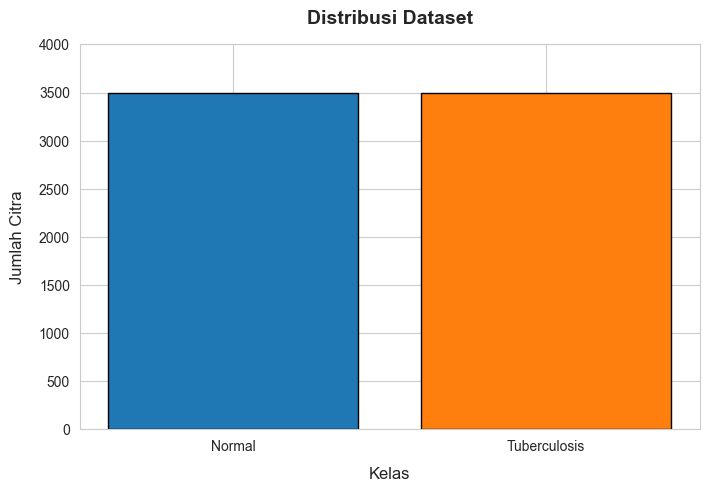

In [5]:
# Distribusi Dataset
plt.figure(figsize=(8, 5))
plt.bar(['Normal', 'Tuberculosis'], [num_normal, num_tb],
        color=['#1f77b4', '#ff7f0e'], edgecolor='black')
plt.title('Distribusi Dataset', fontweight='bold', pad=15)
plt.xlabel('Kelas', labelpad=10)
plt.ylabel('Jumlah Citra', labelpad=10)
plt.ylim(0, 4000)
plt.show()


In [6]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(base_dir, transform=data_transforms)
classes = dataset.classes

In [7]:
# Stratified Split dengan K-Fold
# Parameter
num_folds = 1 # Jumlah fold untuk K-Fold Cross Validation
random_state = 42 # Seed agar hasil pembagian data konsisten
test_size = 0.2 # 20% data digunakan sebagai data uji (test)

# Split awal (stratified)
labels = [y for _, y in dataset.samples]

# Melakukan pembagian awal dataset secara stratified
# Dataset dibagi menjadi data train+validation dan data test
# Stratified digunakan agar proporsi kelas tetap seimbang
train_val_idx, test_idx = train_test_split(
    range(len(dataset)),
    test_size=test_size,
    stratify=labels,
    random_state=random_state
)

# Subset untuk K-Fold
train_val_subset = Subset(dataset, train_val_idx) # Data latih + validasi
test_subset = Subset(dataset, test_idx) # Data uji (test)

train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=0.2,
    stratify=[labels[i] for i in train_val_idx],
    random_state=random_state
)


# Verifikasi distribusi per fold
# Verifikasi distribusi 1 fold
train_n = sum([labels[i] == 0 for i in train_idx])
train_tb = sum([labels[i] == 1 for i in train_idx])
val_n = sum([labels[i] == 0 for i in val_idx])
val_tb = sum([labels[i] == 1 for i in val_idx])

print("\nVerifikasi Distribusi Kelas:")
print(f"  Train - Normal: {train_n} | TB: {train_tb}")
print(f"  Val   - Normal: {val_n} | TB: {val_tb}")



Verifikasi Distribusi Kelas:
  Train - Normal: 2240 | TB: 2240
  Val   - Normal: 560 | TB: 560


In [8]:
# Parameter
num_folds = 5
random_state = 42
test_size = 0.2

labels = [y for _, y in dataset.samples]

# Split train+val dan test
train_val_idx, test_idx = train_test_split(
    range(len(dataset)),
    test_size=test_size,
    stratify=labels,
    random_state=random_state
)

train_val_labels = [labels[i] for i in train_val_idx]
train_val_subset = Subset(dataset, train_val_idx)
test_subset = Subset(dataset, test_idx)

# K-Fold Cross Validation
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state)

# Verifikasi distribusi
print("\nVerifikasi Distribusi Kelas per Fold:")
for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_subset, train_val_labels)):
    train_n = sum([train_val_labels[i] == 0 for i in train_idx])
    train_tb = sum([train_val_labels[i] == 1 for i in train_idx])
    val_n = sum([train_val_labels[i] == 0 for i in val_idx])
    val_tb = sum([train_val_labels[i] == 1 for i in val_idx])
    print(f"\nFold {fold+1}:")
    print(f" Train - Normal: {train_n} | TB: {train_tb}")
    print(f" Val   - Normal: {val_n} | TB: {val_tb}")


Verifikasi Distribusi Kelas per Fold:

Fold 1:
 Train - Normal: 2240 | TB: 2240
 Val   - Normal: 560 | TB: 560

Fold 2:
 Train - Normal: 2240 | TB: 2240
 Val   - Normal: 560 | TB: 560

Fold 3:
 Train - Normal: 2240 | TB: 2240
 Val   - Normal: 560 | TB: 560

Fold 4:
 Train - Normal: 2240 | TB: 2240
 Val   - Normal: 560 | TB: 560

Fold 5:
 Train - Normal: 2240 | TB: 2240
 Val   - Normal: 560 | TB: 560


In [9]:
!pip install torchinfo


In [10]:
# Inisialisasi Model ResNet-18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nMenggunakan device: {device}")

# Arsitektur model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(classes))
)
model = model.to(device)

# Summary model
print("\nModel Summary:")
from torchinfo import summary
summary(model, input_size=(1, 3, 224, 224))


Menggunakan device: cpu

Model Summary:


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [11]:
def train_fold(fold, train_idx, val_idx):
    # Gunakan indeks global dataset
    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=32, shuffle=True)
    val_loader = DataLoader(Subset(dataset, val_idx), batch_size=32, shuffle=False)

    # Inisialisasi model baru tiap fold
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, len(classes))
    )
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.1)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(25):
        # ===== Training =====
        model.train()
        train_loss, train_correct = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

In [12]:
# Performa Training
def plot_training_history(history, fold):
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    # Plot accuracy
    ax[0].plot(history['train_acc'], label='Train Accuracy', color='#1f77b4', marker='o')
    ax[0].plot(history['val_acc'], label='Validation Accuracy', color='#ff7f0e', marker='o')
    ax[0].set_title(f'Fold {fold+1} - Accuracy', fontweight='bold')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Plot loss
    ax[1].plot(history['train_loss'], label='Train Loss', color='#2ca02c', marker='o')
    ax[1].plot(history['val_loss'], label='Validation Loss', color='#d62728', marker='o')
    ax[1].set_title(f'Fold {fold+1} - Loss', fontweight='bold')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [13]:
# Evaluasi Model
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy()[:,1])

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Print raw confusion matrix values
    print("\nRaw Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                annot_kws={'size': 14, 'color': 'black', 'weight': 'bold'},
                cbar=False)
    plt.title('Confusion Matrix', fontweight='bold', pad=15)
    plt.xlabel('Predicted Label', labelpad=12)
    plt.ylabel('True Label', labelpad=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Confusion Matriks
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.5, str(cm[i, j]),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white', fontsize=12)

    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = roc_auc_score(all_labels, all_probs)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='#1f77b4', lw=2,
             label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Receiver Operating Characteristic', fontweight='bold', pad=15)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    return all_labels, all_preds, all_probs

In [14]:
# Implementasi Grad-CAM
def grad_cam(model, image_path):
    # Load dan preprocess gambar
    original_img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(original_img).unsqueeze(0).to(device)

    # Forward pass untuk prediksi
    model.eval()
    features, gradients = None, None

    def forward_hook(module, input, output):
        nonlocal features
        features = output.detach()

    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0].detach()

    # Hook ke layer4 ResNet-18
    handle_forward = model.layer4.register_forward_hook(forward_hook)
    handle_backward = model.layer4.register_backward_hook(backward_hook)

    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    confidence = torch.softmax(output, dim=1)[0][pred_class].item()

    # Hitung Grad-CAM
    output[:, pred_class].backward()
    weights = torch.mean(gradients, dim=[2, 3])
    cam = torch.sum(weights[:, :, None, None] * features, dim=1).squeeze()
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    cam = cam.cpu().numpy()
    cam = cv2.resize(cam, (224, 224))

    # 1.Original Image
    plt.figure(figsize=(6, 6))
    plt.imshow(original_img.resize((224, 224)), cmap='gray')
    plt.axis('off')
    plt.show()

    # 2. Overlay Heatmap + Confidence Score
    plt.figure(figsize=(6, 6))

    # Overlay heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlayed_img = cv2.addWeighted(np.array(original_img.resize((224, 224))), 0.5, heatmap, 0.5, 0)

    plt.imshow(overlayed_img)
    plt.title(f'Confidence: {confidence*100:.1f}%', fontsize=12, pad=10)
    plt.axis('off')
    plt.show()

    # Hapus hooks
    handle_forward.remove()
    handle_backward.remove()

In [ ]:
if __name__ == "__main__":
    all_histories = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_subset, train_val_labels)):
        print(f"\n{'='*40}")
        print(f"Training Fold {fold+1}/{num_folds}")
        print(f"{'='*40}")
        history = train_fold(fold, train_idx, val_idx)
        all_histories.append(history)
        plot_training_history(history, fold)

    # Evaluasi model terbaik
    best_fold = np.argmax([max(h['val_acc']) for h in all_histories])
    print(f"\nBest model: Fold {best_fold+1}")

    # Distribusi test set
    test_labels = [labels[i] for i in test_idx]
    print("\nDistribusi Test Set:")
    print(f"Normal: {test_labels.count(0)}, Tuberculosis: {test_labels.count(1)}")

    # Load model terbaik
    model.load_state_dict(torch.load(f'best_model_fold{best_fold+1}.pth'))
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

    # Evaluasi
    true_labels, all_preds, all_probs = evaluate_model(model, test_loader)

    # Contoh Grad-CAM
    sample_normal = os.path.join(normal_dir, os.listdir(normal_dir)[0])
    sample_tb = os.path.join(tb_dir, os.listdir(tb_dir)[0])
    print("\nContoh Grad-CAM untuk Normal:")
    grad_cam(model, sample_normal)
    print("\nContoh Grad-CAM untuk Tuberculosis:")
    grad_cam(model, sample_tb)


Training Fold 1/5
